# Ivy Portfolio + Long Straddle Hedge

Recreated from the original ivy portfolio notebook, updated for the modern codebase.

The [Ivy Portfolio](https://www.amazon.es/Ivy-Portfolio-Invest-Endowments-Markets/dp/1118008855) is an endowment-inspired equal-weight allocation across 5 asset classes:
- **VTI** — Domestic stocks (20%)
- **VEU** — International stocks (20%)
- **BND** — Bonds (20%)
- **VNQ** — Real estate / REITs (20%)
- **DBC** — Commodities (20%)

We overlay a **3% long straddle** (buy ATM call + put) for tail-risk hedging.

**Note:** This notebook requires multi-asset stock data. If you only have SPY data, use SPY as a proxy.

In [1]:
import math
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

PROJECT_ROOT = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PROJECT_ROOT)
os.chdir(PROJECT_ROOT)

from options_portfolio_backtester import BacktestEngine as Backtest, Stock, Type, Direction
from options_portfolio_backtester import HistoricalOptionsData, TiingoData
from options_portfolio_backtester import Strategy, StrategyLeg
from options_portfolio_backtester import summary
from options_portfolio_backtester.analytics.charts import returns_chart, returns_histogram, monthly_returns_heatmap

sns.set_theme(style='whitegrid', palette='muted')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['figure.dpi'] = 110

print('Setup done.')

Setup done.


## Load Data

We use SPY as the single stock + options data. For a true Ivy Portfolio you'd need multi-asset stock data.

In [2]:
options_data = HistoricalOptionsData('data/processed/options.csv')
stocks_data = TiingoData('data/processed/stocks.csv')
schema = options_data.schema

print(f'Date range: {stocks_data.start_date} to {stocks_data.end_date}')
print(f'Available symbols: {stocks_data._data["symbol"].unique()}')

Date range: 2008-01-02 00:00:00 to 2025-12-12 00:00:00
Available symbols: ['SPY']


## Define Long Straddle Strategy

Buy both an ATM call and ATM put:
- Entry: DTE 60+ days, strike within 5% of spot
- Exit: DTE <= 30 (hold ~1 month)

In [3]:
straddle = Strategy(schema)

# Leg 1: BUY call (ATM)
leg1 = StrategyLeg('leg_1', schema, option_type=Type.CALL, direction=Direction.BUY)
leg1.entry_filter = (
    (schema.underlying == 'SPY') &
    (schema.dte >= 60) &
    (schema.strike >= schema.underlying_last * 0.95) &
    (schema.strike <= schema.underlying_last * 1.05)
)
leg1.exit_filter = (schema.dte <= 30)

# Leg 2: BUY put (ATM)
leg2 = StrategyLeg('leg_2', schema, option_type=Type.PUT, direction=Direction.BUY)
leg2.entry_filter = (
    (schema.underlying == 'SPY') &
    (schema.dte >= 60) &
    (schema.strike >= schema.underlying_last * 0.95) &
    (schema.strike <= schema.underlying_last * 1.05)
)
leg2.exit_filter = (schema.dte <= 30)

straddle.add_legs([leg1, leg2])
straddle.add_exit_thresholds(profit_pct=math.inf, loss_pct=math.inf)

print(f'Long straddle: {len(straddle.legs)} legs')

Long straddle: 2 legs


## Run Backtest

97% SPY + 3% long straddle, monthly rebalance (mimicking the original Ivy Portfolio + hedge concept).

In [4]:
bt = Backtest({'stocks': 0.97, 'options': 0.03, 'cash': 0.0}, initial_capital=1_000_000)
bt.stocks = [Stock('SPY', 1.0)]
bt.stocks_data = stocks_data
bt.options_strategy = straddle
bt.options_data = options_data
bt.run(rebalance_freq=1)

print(f'Trades executed: {len(bt.trade_log)}')

Trades executed: 396


## Results

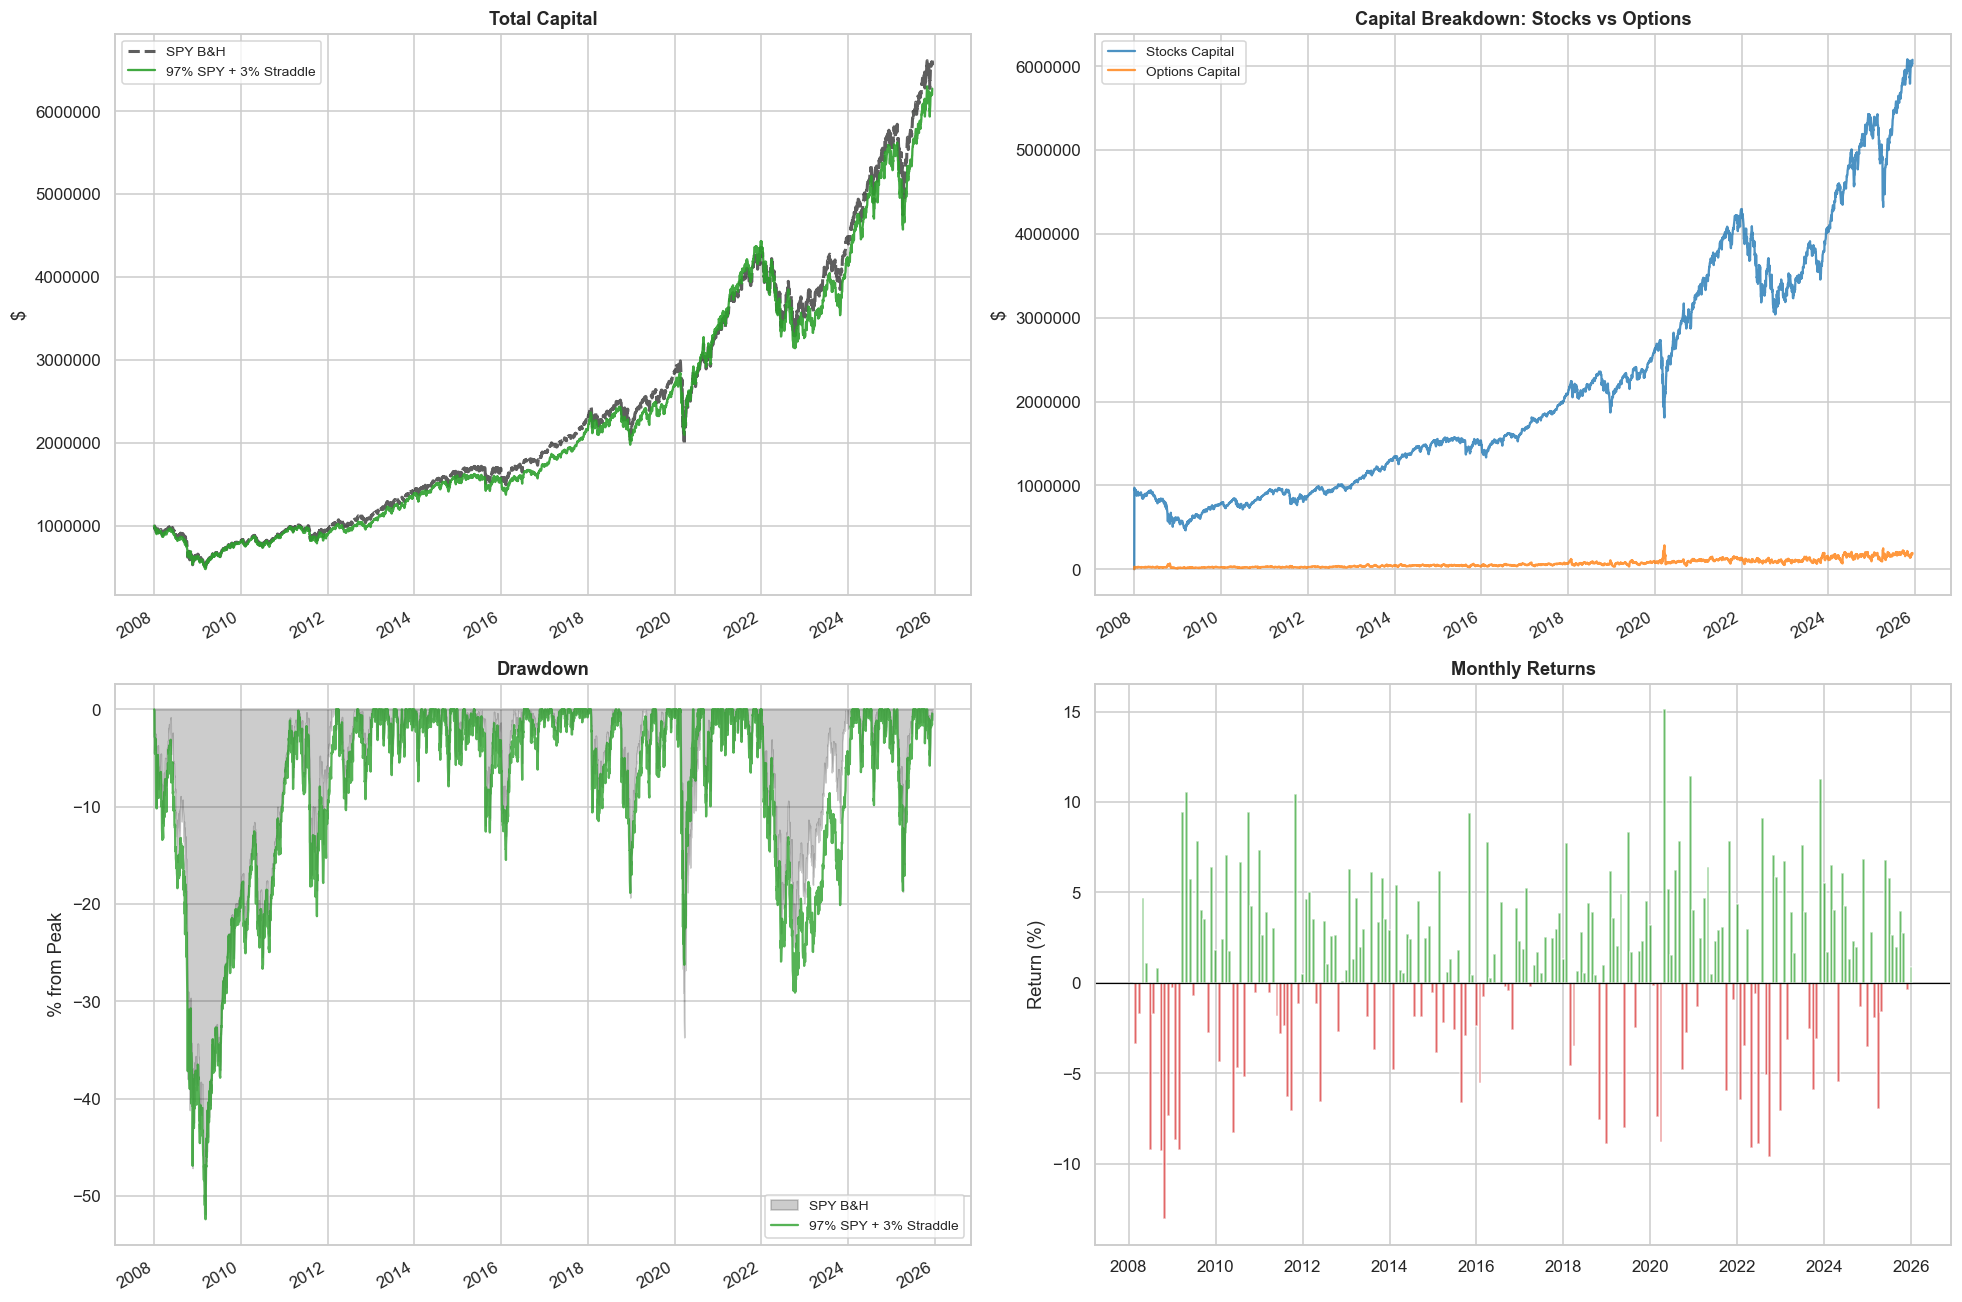

97% SPY + 3% Straddle: 527.2% total, 10.77%/yr, -52.4% max DD
SPY B&H:               555.5% total, 11.05%/yr
Excess:                -0.27%/yr


In [5]:
spy = stocks_data._data[stocks_data._data['symbol'] == 'SPY'].set_index('date')['adjClose'].sort_index()
spy_norm = spy / spy.iloc[0] * 1_000_000

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Capital curve
ax = axes[0, 0]
ax.plot(spy_norm.index, spy_norm.values, 'k--', lw=2, label='SPY B&H', alpha=0.7)
bt.balance['total capital'].plot(ax=ax, label='97% SPY + 3% Straddle', color='#2ca02c', alpha=0.9, lw=1.5)
ax.set_title('Total Capital', fontsize=12, fontweight='bold')
ax.set_ylabel('$')
ax.ticklabel_format(style='plain', axis='y')
ax.legend(fontsize=9)

# Stock capital breakdown
ax = axes[0, 1]
bt.balance['stocks capital'].plot(ax=ax, label='Stocks Capital', color='#1f77b4', alpha=0.8)
bt.balance['options capital'].plot(ax=ax, label='Options Capital', color='#ff7f0e', alpha=0.8)
ax.set_title('Capital Breakdown: Stocks vs Options', fontsize=12, fontweight='bold')
ax.set_ylabel('$')
ax.ticklabel_format(style='plain', axis='y')
ax.legend(fontsize=9)

# Drawdown
ax = axes[1, 0]
total_cap = bt.balance['total capital']
dd = (total_cap - total_cap.cummax()) / total_cap.cummax() * 100
spy_dd = (spy - spy.cummax()) / spy.cummax() * 100
ax.fill_between(spy_dd.index, spy_dd.values, 0, alpha=0.2, color='black', label='SPY B&H')
dd.plot(ax=ax, color='#2ca02c', alpha=0.8, label='97% SPY + 3% Straddle')
ax.set_title('Drawdown', fontsize=12, fontweight='bold')
ax.set_ylabel('% from Peak')
ax.legend(fontsize=9)

# Monthly returns heatmap-style bar
ax = axes[1, 1]
monthly = bt.balance['total capital'].resample('ME').last().pct_change().dropna() * 100
colors = ['#2ca02c' if r >= 0 else '#d62728' for r in monthly]
ax.bar(monthly.index, monthly.values, width=25, color=colors, alpha=0.7)
ax.set_title('Monthly Returns', fontsize=12, fontweight='bold')
ax.set_ylabel('Return (%)')
ax.axhline(0, color='black', lw=0.8)

plt.tight_layout()
plt.show()

# Key metrics
total_ret = (bt.balance['accumulated return'].iloc[-1] - 1) * 100
years = (spy.index[-1] - spy.index[0]).days / 365.25
annual_ret = ((1 + total_ret / 100) ** (1 / years) - 1) * 100
spy_total = (spy.iloc[-1] / spy.iloc[0] - 1) * 100
spy_annual = ((1 + spy_total / 100) ** (1 / years) - 1) * 100

print(f'97% SPY + 3% Straddle: {total_ret:.1f}% total, {annual_ret:.2f}%/yr, {dd.min():.1f}% max DD')
print(f'SPY B&H:               {spy_total:.1f}% total, {spy_annual:.2f}%/yr')
print(f'Excess:                {annual_ret - spy_annual:+.2f}%/yr')

In [6]:
if len(bt.trade_log) > 0:
    summary(bt.trade_log, bt.balance)

In [7]:
returns_chart(bt.balance)

alt.VConcatChart(...)

In [8]:
monthly_returns_heatmap(bt.balance)

alt.Chart(...)

## Analysis

The original Ivy Portfolio concept uses 5 uncorrelated asset classes for diversification. Here we approximate with SPY only (a limitation of single-underlying data).

The long straddle overlay:
- **Pays off during sharp moves** in either direction (crashes or rallies)
- **Bleeds premium** in calm, range-bound markets (theta decay)
- **Acts as volatility insurance** for the equity portfolio
- At 3% allocation, the drag is modest but the protection limited

For a true Ivy Portfolio backtest, you'd need data for VTI, VEU, BND, VNQ, and DBC.